In [1]:
import copy
import pickle
import pdb

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from matplotlib.colors import Normalize
import corner
import chainconsumer

from scipy import optimize
import astropy
from astropy.time import Time
from astropy.timeseries import LombScargle

import radvel
from radvel.plot import orbit_plots, mcmc_plots

import rvsearch
from rvsearch import search, utils

from analysis_scripts import sval_correlations

%matplotlib inline

# Notebook for handling data post-processing, such as S-value decorrelation, and modeling of yearly systematics.

## Model HD 3765 activity with square-exponential kernel. Set up the file here, run on cadence.

In [3]:
post = radvel.posterior.load('./special_systems/3765/post_final.pkl')
data = pd.read_csv('../rvdata/vst3765.csv')

t = np.array(data.jd)
vel = np.array(data.mnvel)
errvel = np.array(data.errvel)
tel = np.array(data.tel)

telgrps = data.groupby('tel').groups
instnames = telgrps.keys()

In [5]:
post.params

Parameters([('per1',
             Parameter object: value = 1235.8553164376942, vary = True, mcmc scale = None),
            ('tc1',
             Parameter object: value = 2455618.025629988, vary = True, mcmc scale = None),
            ('secosw1',
             Parameter object: value = -0.012123674495171316, vary = True, mcmc scale = 0.005),
            ('sesinw1',
             Parameter object: value = -0.6324900170543468, vary = True, mcmc scale = 0.005),
            ('k1',
             Parameter object: value = 4.013436136166362, vary = True, mcmc scale = None),
            ('jit_j',
             Parameter object: value = 3.027068490583884, vary = True, mcmc scale = None),
            ('jit_k',
             Parameter object: value = 4.799254850767471, vary = True, mcmc scale = None),
            ('gamma_j',
             Parameter object: value = -0.6631529318729545, vary = False, mcmc scale = None),
            ('gamma_k',
             Parameter object: value = -0.47255188547620375,

In [6]:
nplanets = 1
params = radvel.Parameters(nplanets, basis='per tc secosw sesinw k')

params['per1'] = radvel.Parameter(value=1235.855, vary=True)
params['tc1'] = radvel.Parameter(value=2455618.0256, vary=True)
params['secosw1'] = radvel.Parameter(value=-0.01212367,vary=True)
params['sesinw1'] = radvel.Parameter(value=-0.63249002,vary=True)
params['k1'] = radvel.Parameter(value=4.0134, vary=True)
params['dvdt'] = radvel.Parameter(value=0.,vary=False)
params['curv'] = radvel.Parameter(value=0.,vary=False)

#Model activity with square-exponential term.
amp       = 2.98
explength = 1500 

params['gp_amp'] = radvel.Parameter(value=amp, vary=True)
params['gp_length'] = radvel.Parameter(value=explength, vary=True)

In [7]:
hnames = [
    'gp_amp', # eta_1; GP variability amplitude
    'gp_length' # eta_2; GP non-periodic characteristic length
]

model = radvel.model.RVModel(params)

# Make HIRES post-upgrade likelihood.
indices = telgrps['j']
like_j = radvel.likelihood.GPLikelihood(model, t[indices], vel[indices],
                                            errvel[indices], hnames, 
                                            suffix='_j',
                                            kernel_name="SqExp"
                                            )
like_j.params['gamma_j'] = radvel.Parameter(value=-0.2894, vary=False, linear=True)
like_j.params['jit_j'] = radvel.Parameter(value=3.338, vary=True)

# Make HIRES pre-upgrade likelihood.
indices = telgrps['k']
like_k = radvel.likelihood.GPLikelihood(model, t[indices], vel[indices],
                                          errvel[indices], hnames, 
                                          suffix='_k',
                                          kernel_name="SqExp"
                                          )
like_k.params['gamma_k'] = radvel.Parameter(value=-1.7889, vary=False, linear=True)
like_k.params['jit_k'] = radvel.Parameter(value=3.670, vary=True)
likes = [like_j, like_k]

gplike = radvel.likelihood.CompositeLikelihood(likes)
gppost = radvel.posterior.Posterior(gplike)
gppost.priors += [radvel.prior.Jeffreys('gp_amp', 0.01, 50.)]
gppost.priors += [radvel.prior.HardBounds('gp_length', 0, 8000)]

In [9]:
res = optimize.minimize(
      gppost.neglogprob_array, gppost.get_vary_params(), method='Powell',
      options=dict(maxiter=500, maxfev=100000, xatol=1e-8)
      )
print(gppost)

parameter                     value      vary
per1                        1214.75       True
tc1                     2.45562e+06       True
secosw1                 -0.00502474       True
sesinw1                   -0.545819       True
k1                          3.83836       True
dvdt                              0      False
curv                              0      False
gp_amp                      1.77397       True
gp_length                   1096.63       True
gamma_j                     -0.2894      False
jit_j                       2.68183       True
gamma_k                     -1.7889      False
jit_k                        3.9112       True

Priors
------
Jeffrey's prior on gp_amp, min=0.01, max=50.0
Bounded prior on gp_length, min=0, max=8000



In [46]:
nwalkers = 20
nrun = 100
chains = radvel.mcmc(gppost, nwalkers=nwalkers, nrun=nrun, burnGR=1.03,
                     maxGR=1.0075, minTz=2000, minAfactor=15,
                     maxArchange=0.07, burnAfactor=15,
                     minsteps=0.5*nwalkers*nrun, minpercent=20, thin=5,
                     save=False, ensembles=12)

12000/24000 (50.0%) steps complete; Running 41.57 steps/s; Mean acceptance rate = 47.1%; Min Auto Factor =  27; Max Auto Relative-Change = 0.423; Min Tz = 6031.1; Max G-R = 1.011
Discarding burn-in now that the chains are marginally well-mixed

24000/24000 (100.0%) steps complete; Running 47.11 steps/s; Mean acceptance rate = 35.1%; Min Auto Factor =  18; Max Auto Relative-Change = 0.596; Min Tz = 1816.0; Max G-R = 1.038

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


## Download chains from cadence.

In [18]:
cadence_chains = pd.read_csv('../3765_gp_chains.csv.tar.bz2')

clip_chains = cadence_chains.query('k1 < 7.5 and gp_amp < 8 and jit_k > 0')
quants = clip_chains.quantile([0.159, 0.5, 0.841])
gppost.uparams   = {}
gppost.medparams = {}
gppost.maxparams = {}

for par in gppost.params.keys():
    if gppost.params[par].vary:
        med = quants[par][0.5]
        high = quants[par][0.841] - med
        low = med - quants[par][0.159]
        err = np.mean([high,low])
        err = radvel.utils.round_sig(err)
        med, err, errhigh = radvel.utils.sigfig(med, err)
        max, err, errhigh = radvel.utils.sigfig(
                            gppost.params[par].value, err)

        gppost.uparams[par] = err
        gppost.medparams[par] = med
        gppost.maxparams[par] = max

synthchains = gppost.params.basis.to_synth(clip_chains)
synthquants = synthchains.quantile([0.159, 0.5, 0.841])

for n in np.arange(1, gppost.params.num_planets+1):
    e_key = 'e{}'.format(n)
    w_key = 'w{}'.format(n)
    # Add period if it's a synthetic parameter.
    per_key = 'per{}'.format(n)

    med_e  = synthquants[e_key][0.5]
    high_e = synthquants[e_key][0.841] - med_e
    low_e  = med_e - synthquants[e_key][0.159]
    err_e  = np.mean([high_e,low_e])
    err_e  = radvel.utils.round_sig(err_e)
    med_e, err_e, errhigh_e = radvel.utils.sigfig(med_e, err_e)
    max_e, err_e, errhigh_e = radvel.utils.sigfig(
                              gppost.params[e_key].value, err_e)

    med_w  = synthquants[w_key][0.5]
    high_w = synthquants[w_key][0.841] - med_w
    low_w  = med_w - synthquants[w_key][0.159]
    err_w  = np.mean([high_w,low_w])
    err_w  = radvel.utils.round_sig(err_w)
    med_w, err_w, errhigh_w = radvel.utils.sigfig(med_w, err_w)
    max_w, err_w, errhigh_w = radvel.utils.sigfig(
                              gppost.params[w_key].value, err_w)

    gppost.uparams[e_key]   = err_e
    gppost.uparams[w_key]   = err_w
    gppost.medparams[e_key] = med_e
    gppost.medparams[w_key] = med_w
    gppost.maxparams[e_key] = max_e
    gppost.maxparams[w_key] = max_w

In [21]:
gppost.params

Parameters([('per1',
             Parameter object: value = 1214.748463107038, vary = True, mcmc scale = None),
            ('tc1',
             Parameter object: value = 2455616.3278694903, vary = True, mcmc scale = None),
            ('secosw1',
             Parameter object: value = -0.005024737643588559, vary = True, mcmc scale = None),
            ('sesinw1',
             Parameter object: value = -0.545818666954859, vary = True, mcmc scale = None),
            ('k1',
             Parameter object: value = 3.83836058793202, vary = True, mcmc scale = None),
            ('dvdt',
             Parameter object: value = 0.0, vary = False, mcmc scale = None),
            ('curv',
             Parameter object: value = 0.0, vary = False, mcmc scale = None),
            ('gp_amp',
             Parameter object: value = 1.7739684735903196, vary = True, mcmc scale = None),
            ('gp_length',
             Parameter object: value = 1096.626309841606, vary = True, mcmc scale = None),
  

KeyError: 'e1'

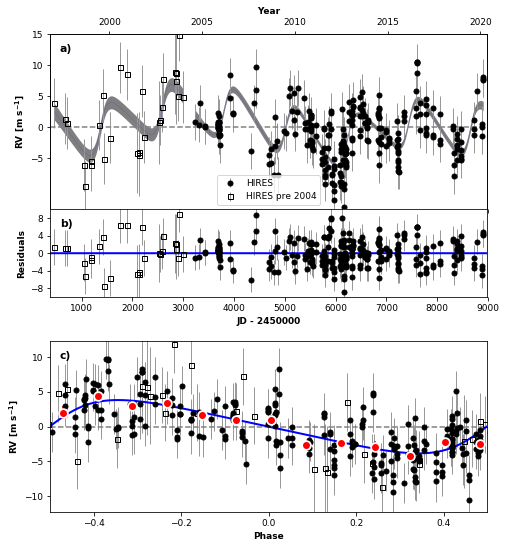

In [12]:
GPPlot = orbit_plots.GPMultipanelPlot(
         gppost, uparams=gppost.uparams,
         saveplot='3765_gp.pdf',
         subtract_gp_mean_model=False,
         plot_likelihoods_separately=False,
         subtract_orbit_model=False
         )
GPPlot.plot_multipanel()
GPPlot.saveplot()

Corner plot saved to ../3765_gp_dcorner.pdf


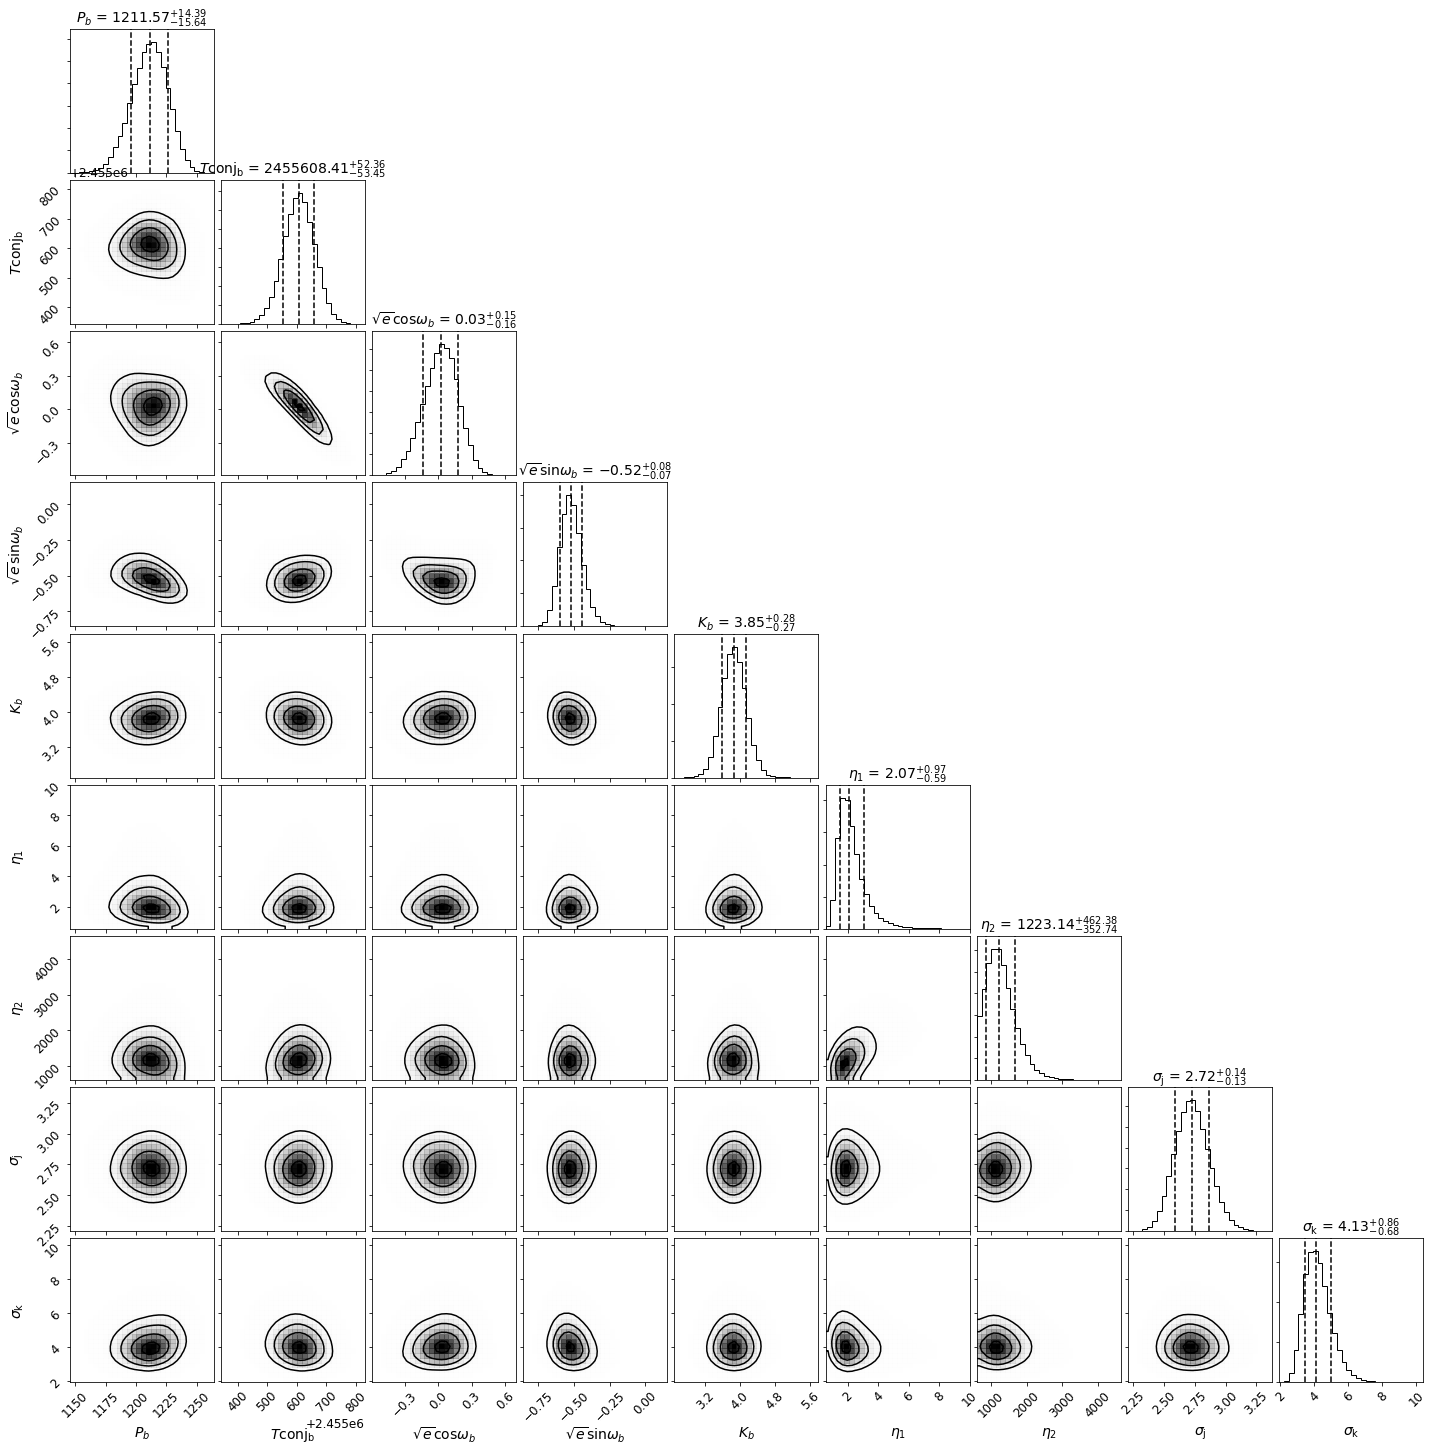

In [22]:
Corner = mcmc_plots.CornerPlot(gppost, cadence_chains,
                               saveplot='../3765_gp_dcorner.pdf')
figure = Corner.plot()

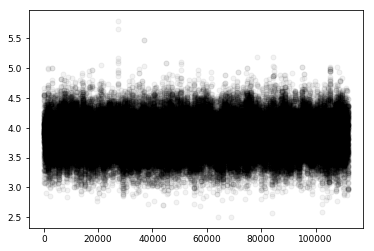

In [88]:
k = cadence_chains['k1'] 
#.query('k1 < 7.5 and gp_amp < 8')
fig, ax = plt.subplots()
ax.scatter(np.arange(len(k)), k, alpha=0.05, color='black')

## Same for HD 107148.

In [58]:
post = radvel.posterior.load('./special_systems/107148/post_final.pkl')
data = pd.read_csv('../rvdata/vst107148.csv')

t = np.array(data.jd)
vel = np.array(data.mnvel)
errvel = np.array(data.errvel)
tel = np.array(data.tel)

telgrps = data.groupby('tel').groups
instnames = telgrps.keys()

In [22]:
post.params

Parameters([('per1',
             Parameter object: value = 77.18308073817327, vary = True, mcmc scale = None),
            ('tc1',
             Parameter object: value = 2456092.7895222357, vary = True, mcmc scale = None),
            ('secosw1',
             Parameter object: value = -0.24981213097885674, vary = True, mcmc scale = 0.005),
            ('sesinw1',
             Parameter object: value = -0.36898214250555494, vary = True, mcmc scale = 0.005),
            ('k1',
             Parameter object: value = 9.382069512000488, vary = True, mcmc scale = None),
            ('per2',
             Parameter object: value = 18.327170768423894, vary = True, mcmc scale = None),
            ('tc2',
             Parameter object: value = 2455203.0238911263, vary = True, mcmc scale = None),
            ('secosw2',
             Parameter object: value = 0.37388788153140584, vary = True, mcmc scale = 0.005),
            ('sesinw2',
             Parameter object: value = -0.48737839235231456, 

In [59]:
nplanets = 2
params = radvel.Parameters(nplanets, basis='per tc secosw sesinw k')

params['per1'] = radvel.Parameter(value=77.183, vary=True)
params['tc1'] = radvel.Parameter(value=2456092.790, vary=True)
params['secosw1'] = radvel.Parameter(value=-0.2498,vary=True)
params['sesinw1'] = radvel.Parameter(value=-0.3690,vary=True)
params['k1'] = radvel.Parameter(value=9.382, vary=True)

params['per2'] = radvel.Parameter(value=18.327, vary=True)
params['tc2'] = radvel.Parameter(value=2455203.0239, vary=True)
params['secosw2'] = radvel.Parameter(value=0.3739,vary=True)
params['sesinw2'] = radvel.Parameter(value=-0.4874,vary=True)
params['k2'] = radvel.Parameter(value=5.283, vary=True)

params['dvdt'] = radvel.Parameter(value=0.,vary=False)
params['curv'] = radvel.Parameter(value=0.,vary=False)

#Model activity with square-exponential term.
amp       = 2.98
explength = 2200

params['gp_amp'] = radvel.Parameter(value=amp, vary=True)
params['gp_length'] = radvel.Parameter(value=explength, vary=True)

In [60]:
# Initialize RV model, likelihood, and posterior. Include GP priors.
model = radvel.model.RVModel(params)

# Make HIRES post-upgrade likelihood.
indices = telgrps['j']
like_j = radvel.likelihood.GPLikelihood(model, t[indices], vel[indices],
                                            errvel[indices], hnames,
                                            suffix='_j',
                                            kernel_name="SqExp"
                                            )
like_j.params['gamma_j'] = radvel.Parameter(value=-1.104, vary=False, linear=True)
like_j.params['jit_j'] = radvel.Parameter(value=3.492, vary=True)

# Make HIRES pre-upgrade likelihood.
indices = telgrps['k']
like_k = radvel.likelihood.GPLikelihood(model, t[indices], vel[indices],
                                          errvel[indices], hnames,
                                          suffix='_k',
                                          kernel_name="SqExp"
                                          )
like_k.params['gamma_k'] = radvel.Parameter(value=-3.864, vary=False, linear=True)
like_k.params['jit_k'] = radvel.Parameter(value=4.484, vary=True)

likes = [like_j, like_k]

gplike = radvel.likelihood.CompositeLikelihood(likes)
gppost = radvel.posterior.Posterior(gplike)
gppost.priors += [radvel.prior.Jeffreys('gp_amp', 0.01, 12.)]
gppost.priors += [radvel.prior.HardBounds('gp_length', 500, 5000)]
gppost.priors += [radvel.prior.HardBounds('jit_k', 0.01, 20)]
gppost.priors += [radvel.prior.HardBounds('jit_j', 0.01, 20)]
gppost.priors += [radvel.prior.PositiveKPrior(2)]

In [61]:
res = optimize.minimize(
      gppost.neglogprob_array, gppost.get_vary_params(), method='Powell',
      options=dict(maxiter=500, maxfev=100000, xatol=1e-8)
      )
print(gppost)

parameter                     value      vary
per1                        77.1733       True
tc1                     2.45609e+06       True
secosw1                   -0.188121       True
sesinw1                   -0.345834       True
k1                           9.0684       True
per2                        18.3268       True
tc2                      2.4552e+06       True
secosw2                    0.595963       True
sesinw2                   -0.322355       True
k2                           5.6367       True
dvdt                              0      False
curv                              0      False
gp_amp                       1.5261       True
gp_length                   716.013       True
gamma_j                      -1.104      False
jit_j                       3.01559       True
gamma_k                      -3.864      False
jit_k                       4.28893       True

Priors
------
Jeffrey's prior on gp_amp, min=0.01, max=12.0
Bounded prior on gp_length, min=600, max=5000
B

In [66]:
cadence_chains = pd.read_csv('./special_systems/107148/107148_gp_chains.csv.tar.bz2')

clip_chains = cadence_chains#.query('k1 < 7.5 and gp_amp < 8 and jit_k > 0')
quants = cadence_chains.quantile([0.159, 0.5, 0.841])
gppost.uparams   = {}
gppost.medparams = {}
gppost.maxparams = {}

gppost.params['e1'] = post.params['e1']
gppost.params['w1'] = post.params['w1']
gppost.params['e2'] = post.params['e2']
gppost.params['w2'] = post.params['w2']

for par in gppost.params.keys():
    if gppost.params[par].vary:
        med = quants[par][0.5]
        high = quants[par][0.841] - med
        low = med - quants[par][0.159]
        err = np.mean([high,low])
        err = radvel.utils.round_sig(err)
        med, err, errhigh = radvel.utils.sigfig(med, err)
        max, err, errhigh = radvel.utils.sigfig(
                            gppost.params[par].value, err)

        gppost.uparams[par] = err
        gppost.medparams[par] = med
        gppost.maxparams[par] = max

synthchains = gppost.params.basis.to_synth(clip_chains)
synthquants = synthchains.quantile([0.159, 0.5, 0.841])

for n in np.arange(1, gppost.params.num_planets+1):
    e_key = 'e{}'.format(n)
    w_key = 'w{}'.format(n)
    # Add period if it's a synthetic parameter.
    per_key = 'per{}'.format(n)

    med_e  = synthquants[e_key][0.5]
    high_e = synthquants[e_key][0.841] - med_e
    low_e  = med_e - synthquants[e_key][0.159]
    err_e  = np.mean([high_e,low_e])
    err_e  = radvel.utils.round_sig(err_e)
    med_e, err_e, errhigh_e = radvel.utils.sigfig(med_e, err_e)
    max_e, err_e, errhigh_e = radvel.utils.sigfig(
                              gppost.params[e_key].value, err_e)

    med_w  = synthquants[w_key][0.5]
    high_w = synthquants[w_key][0.841] - med_w
    low_w  = med_w - synthquants[w_key][0.159]
    err_w  = np.mean([high_w,low_w])
    err_w  = radvel.utils.round_sig(err_w)
    med_w, err_w, errhigh_w = radvel.utils.sigfig(med_w, err_w)
    max_w, err_w, errhigh_w = radvel.utils.sigfig(
                              gppost.params[w_key].value, err_w)

    gppost.uparams[e_key]   = err_e
    gppost.uparams[w_key]   = err_w
    gppost.medparams[e_key] = med_e
    gppost.medparams[w_key] = med_w
    gppost.maxparams[e_key] = max_e
    gppost.maxparams[w_key] = max_w

RV multi-panel plot saved to special_systems/107148_gp.pdf


TypeError: 'str' object is not callable

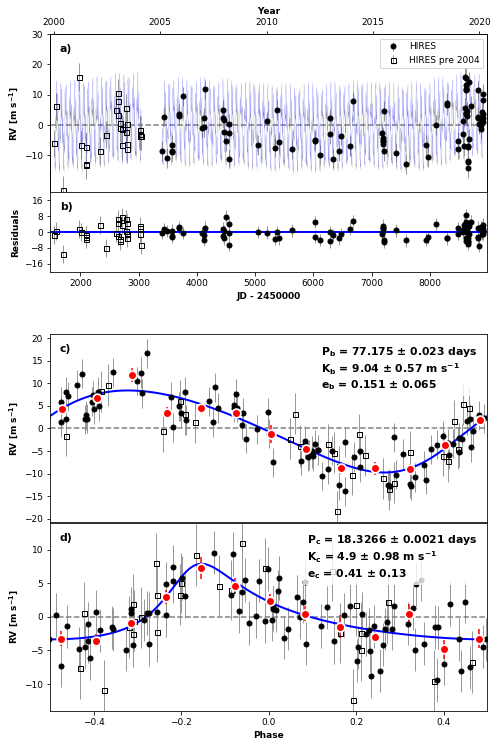

In [68]:
GPPlot = orbit_plots.GPMultipanelPlot(gppost,
         uparams=gppost.uparams,
         saveplot='special_systems/107148_gp.pdf',
         subtract_gp_mean_model=False,
         plot_likelihoods_separately=False,
         subtract_orbit_model=False
         ) #uparams=gppost.uparams,
GPPlot.plot_multipanel()
GPPlot.saveplot()

Corner plot saved to special_systems/107148_gp_dcorner.pdf


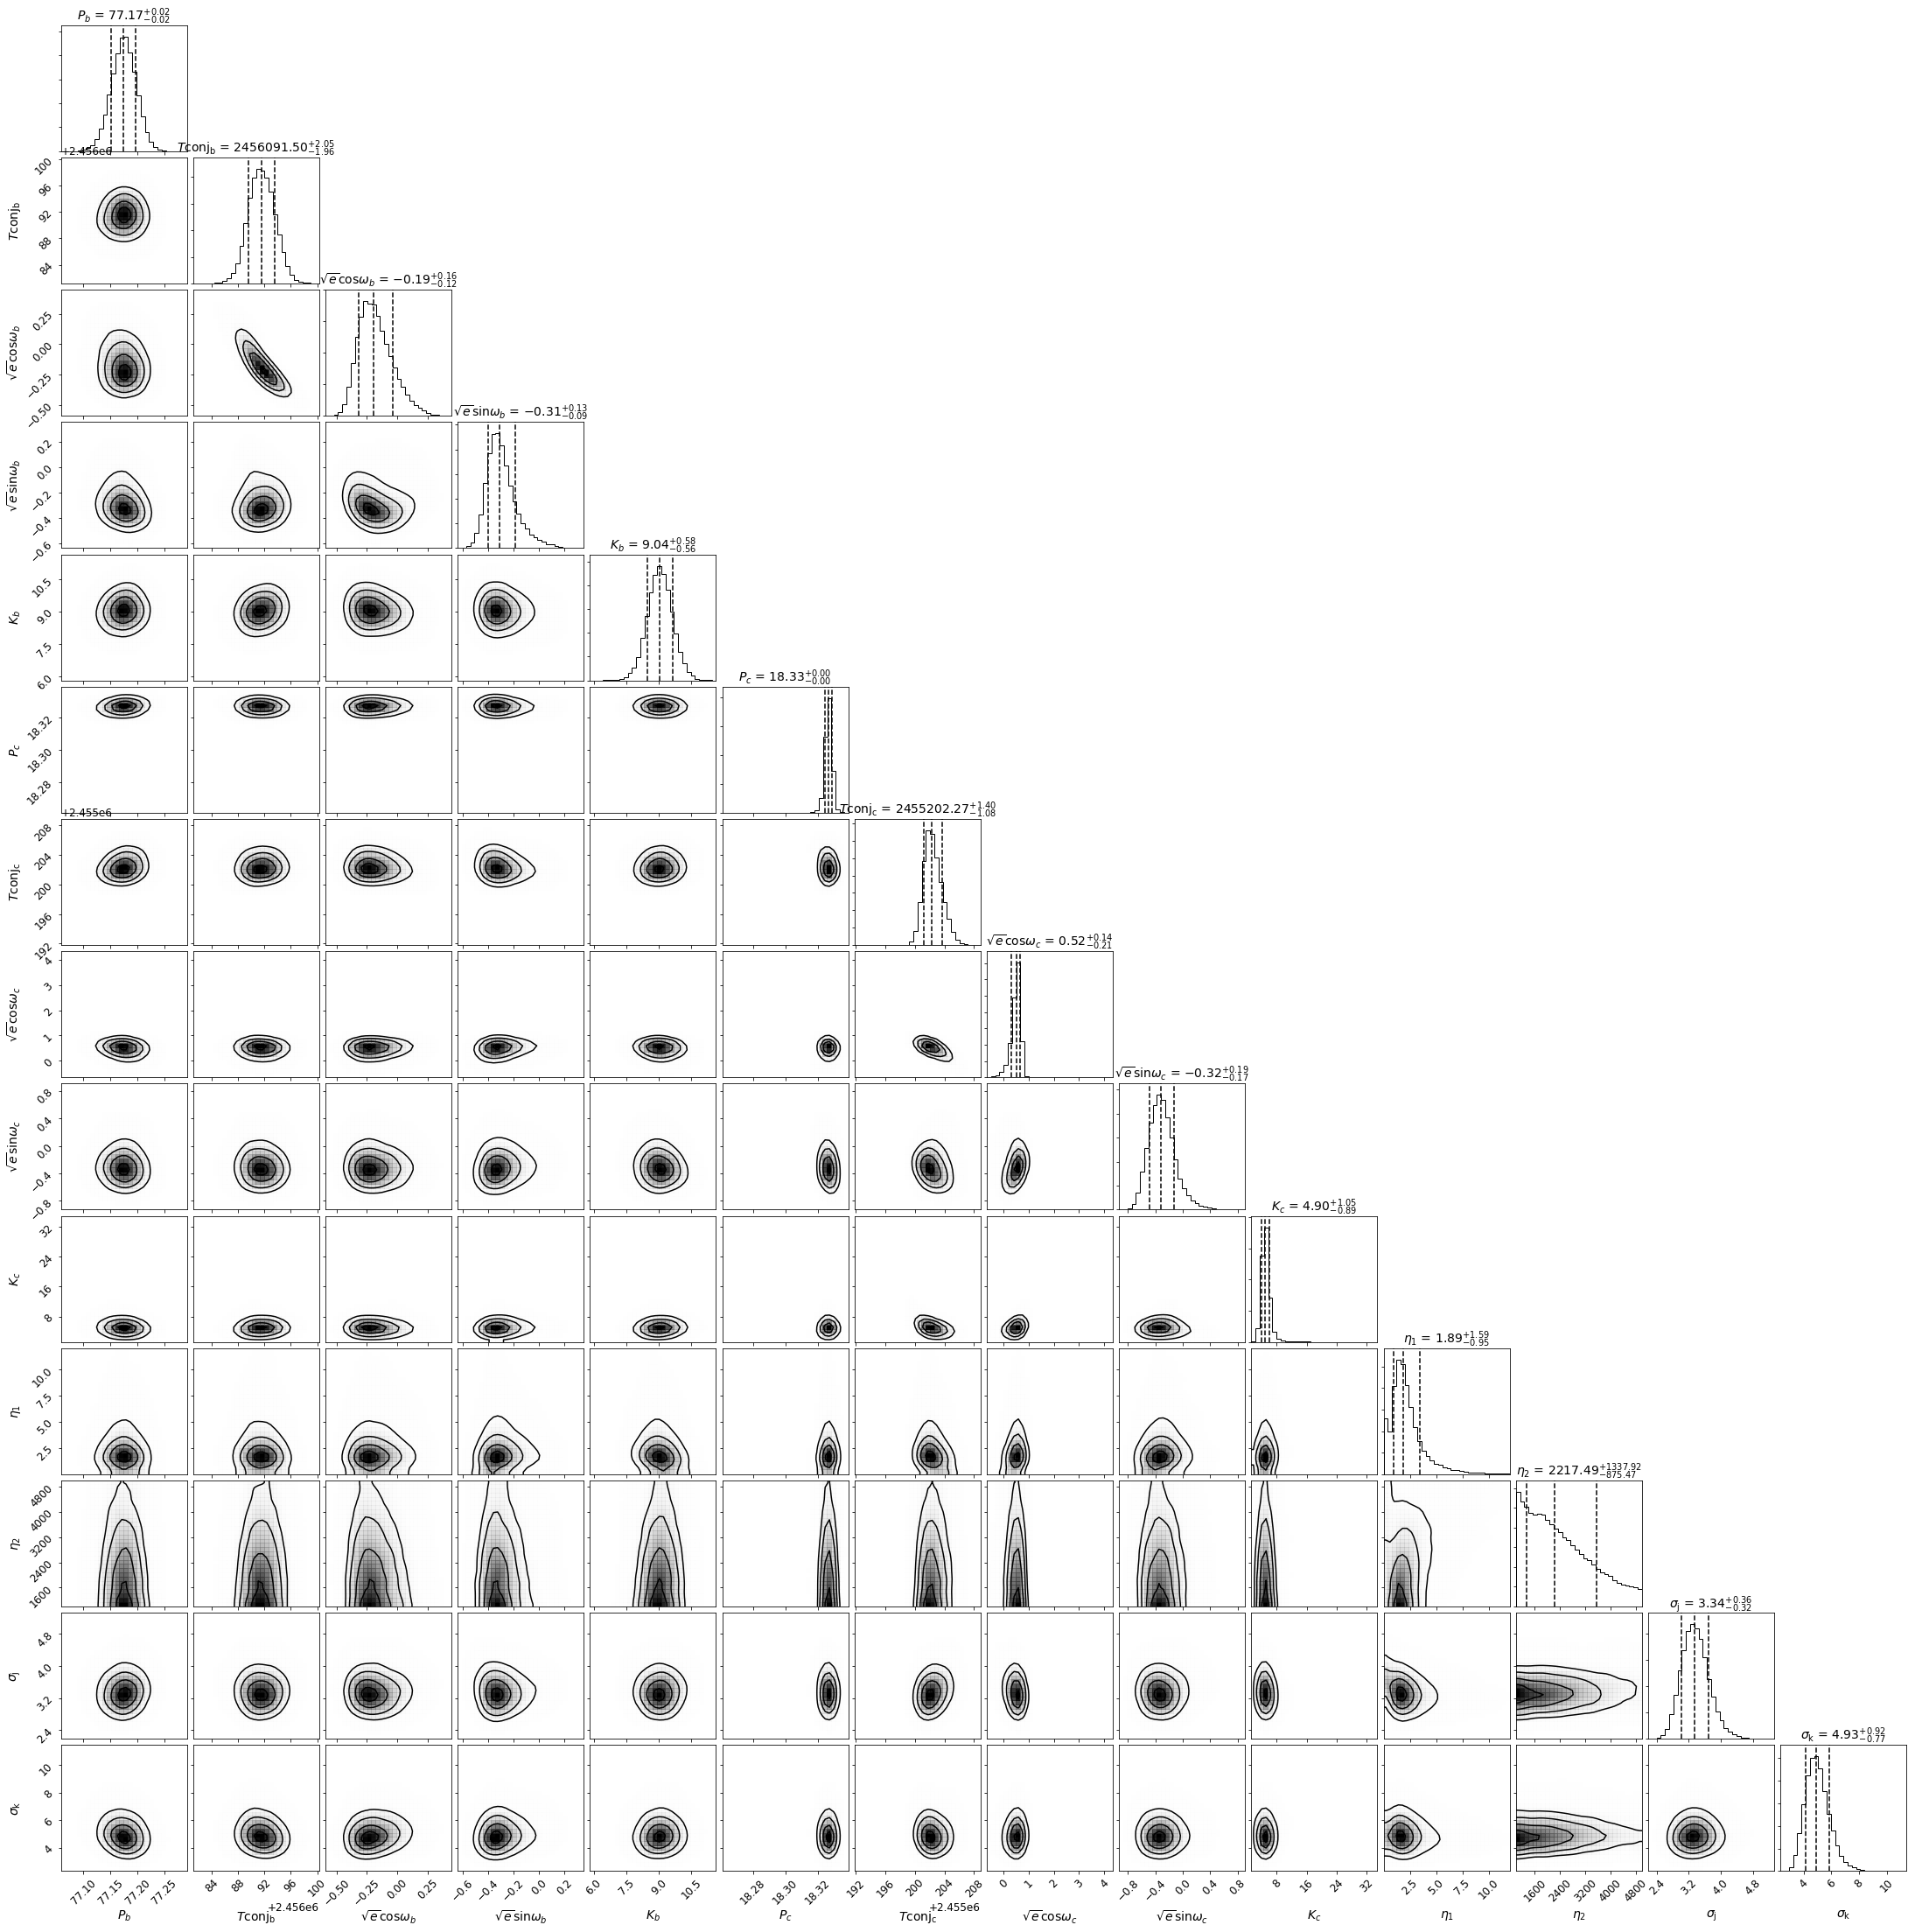

In [69]:
Corner = mcmc_plots.CornerPlot(gppost, cadence_chains,
                               saveplot='special_systems/107148_gp_corner.pdf')
figure = Corner.plot()

## Same for HD 156668.

In [108]:
post = radvel.posterior.load('./special_systems/156668/post_final.pkl')
data = pd.read_csv('../rvdata/vst156668.csv').query('tel != "k" and cts > 3000').reset_index()

t = np.array(data.jd)
vel = np.array(data.mnvel)
errvel = np.array(data.errvel)
tel = np.array(data.tel)

telgrps = data.groupby('tel').groups
instnames = telgrps.keys()

In [95]:
post.params

Parameters([('per1',
             Parameter object: value = 811.5003891110609, vary = True, mcmc scale = None),
            ('tc1',
             Parameter object: value = 2455900.717827225, vary = True, mcmc scale = None),
            ('secosw1',
             Parameter object: value = -0.317732032850538, vary = True, mcmc scale = 0.005),
            ('sesinw1',
             Parameter object: value = 0.10471615700951345, vary = True, mcmc scale = 0.005),
            ('k1',
             Parameter object: value = 2.6105241540856863, vary = True, mcmc scale = None),
            ('per2',
             Parameter object: value = 4.642747419864077, vary = True, mcmc scale = None),
            ('tc2',
             Parameter object: value = 2455201.618914583, vary = True, mcmc scale = None),
            ('secosw2',
             Parameter object: value = -0.36831515169863527, vary = True, mcmc scale = 0.005),
            ('sesinw2',
             Parameter object: value = -0.320870548242183, vary =

In [109]:
nplanets = 2
params = radvel.Parameters(nplanets, basis='per tc secosw sesinw k')

params['per1']    = radvel.Parameter(value=811.500, vary=True)
params['tc1']     = radvel.Parameter(value=2455900.717827, vary=True)
params['secosw1'] = radvel.Parameter(value=-0.317732,vary=True)
params['sesinw1'] = radvel.Parameter(value=0.104716157,vary=True)
params['k1']      = radvel.Parameter(value=2.6105, vary=True)
params['per2']    = radvel.Parameter(value=4.6427474, vary=True)
params['tc2']     = radvel.Parameter(value=2455201.618914583, vary=True)
params['secosw2'] = radvel.Parameter(value=-0.36831515,vary=True)
params['sesinw2'] = radvel.Parameter(value=-0.320870548,vary=True)
params['k2']      = radvel.Parameter(value=2.36642, vary=True)

params['dvdt'] = radvel.Parameter(value=0.,vary=False)
params['curv'] = radvel.Parameter(value=0.,vary=False)

#Model activity with square-exponential term.
amp       = 2.98
explength = 2200 

params['gp_amp'] = radvel.Parameter(value=amp, vary=True)
params['gp_length'] = radvel.Parameter(value=explength, vary=True)

In [115]:
hnames = [
    'gp_amp', # eta_1; GP variability amplitude
    'gp_length' # eta_2; GP non-periodic characteristic length
]
model = radvel.model.RVModel(params)

# Make HIRES post-upgrade likelihood.
indices = telgrps['j']
like_j = radvel.likelihood.GPLikelihood(model, t[indices], vel[indices],
                                            errvel[indices], hnames, 
                                            suffix='_j',
                                            kernel_name="SqExp"
                                            )
like_j.params['gamma_j'] = radvel.Parameter(value=-0.4105, vary=False, linear=True)
like_j.params['jit_j'] = radvel.Parameter(value=2.00, vary=True)
'''
# Make HIRES pre-upgrade likelihood.
indices = telgrps['k']
like_k = radvel.likelihood.GPLikelihood(model, t[indices], vel[indices],
                                          errvel[indices], hnames, 
                                          suffix='_k',
                                          kernel_name="SqExp"
                                          )
like_k.params['gamma_k'] = radvel.Parameter(value=-5.5066, vary=False, linear=True)
like_k.params['jit_k'] = radvel.Parameter(value=5.0, vary=True)
#likes = [like_j, like_k]
'''
# Make APF likelihood.
indices = telgrps['apf']
like_a = radvel.likelihood.GPLikelihood(model, t[indices], vel[indices],
                                          errvel[indices], hnames, 
                                          suffix='_apf',
                                          kernel_name="SqExp"
                                          )
like_a.params['gamma_apf'] = radvel.Parameter(value=0.8867, vary=False, linear=True)
like_a.params['jit_apf'] = radvel.Parameter(value=2.135, vary=True)

likes  = [like_j, like_a]#, like_k]
gplike = radvel.likelihood.CompositeLikelihood(likes)
gppost = radvel.posterior.Posterior(gplike)
gppost.priors += [radvel.prior.Jeffreys('gp_amp', 0.01, 10.)]
gppost.priors += [radvel.prior.HardBounds('gp_length', 500, 3600)]

In [116]:
res = optimize.minimize(
      gppost.neglogprob_array, gppost.get_vary_params(), method='Powell',
      options=dict(maxiter=500, maxfev=100000, xatol=1e-8)
      )
print(gppost)

parameter                     value      vary
per1                        801.621       True
tc1                     2.45589e+06       True
secosw1                   -0.197702       True
sesinw1                     0.17542       True
k1                          2.53303       True
per2                         4.6425       True
tc2                      2.4552e+06       True
secosw2                   -0.383691       True
sesinw2                   -0.303087       True
k2                          2.41998       True
dvdt                              0      False
curv                              0      False
gp_amp                      1.62884       True
gp_length                   728.015       True
gamma_j                     -0.4105      False
jit_j                       1.97046       True
gamma_apf                    0.8867      False
jit_apf                     1.82777       True
tp1                     2.45601e+06           
e1                        0.0939834           
w1            

In [117]:
cadence_chains = pd.read_csv('./special_systems/156668/156668_gp_chains.csv.tar.bz2')

clip_chains = cadence_chains#.query('k1 < 7.5 and gp_amp < 8 and jit_k > 0')
quants = cadence_chains.quantile([0.159, 0.5, 0.841])
gppost.uparams   = {}
gppost.medparams = {}
gppost.maxparams = {}

gppost.params['e1'] = post.params['e1']
gppost.params['w1'] = post.params['w1']
gppost.params['e2'] = post.params['e2']
gppost.params['w2'] = post.params['w2']

for par in gppost.params.keys():
    if gppost.params[par].vary:
        med = quants[par][0.5]
        high = quants[par][0.841] - med
        low = med - quants[par][0.159]
        err = np.mean([high,low])
        err = radvel.utils.round_sig(err)
        med, err, errhigh = radvel.utils.sigfig(med, err)
        max, err, errhigh = radvel.utils.sigfig(
                            gppost.params[par].value, err)

        gppost.uparams[par] = err
        gppost.medparams[par] = med
        gppost.maxparams[par] = max

synthchains = gppost.params.basis.to_synth(clip_chains)
synthquants = synthchains.quantile([0.159, 0.5, 0.841])

for n in np.arange(1, gppost.params.num_planets+1):
    e_key = 'e{}'.format(n)
    w_key = 'w{}'.format(n)
    # Add period if it's a synthetic parameter.
    per_key = 'per{}'.format(n)

    med_e  = synthquants[e_key][0.5]
    high_e = synthquants[e_key][0.841] - med_e
    low_e  = med_e - synthquants[e_key][0.159]
    err_e  = np.mean([high_e,low_e])
    err_e  = radvel.utils.round_sig(err_e)
    med_e, err_e, errhigh_e = radvel.utils.sigfig(med_e, err_e)
    max_e, err_e, errhigh_e = radvel.utils.sigfig(
                              gppost.params[e_key].value, err_e)

    med_w  = synthquants[w_key][0.5]
    high_w = synthquants[w_key][0.841] - med_w
    low_w  = med_w - synthquants[w_key][0.159]
    err_w  = np.mean([high_w,low_w])
    err_w  = radvel.utils.round_sig(err_w)
    med_w, err_w, errhigh_w = radvel.utils.sigfig(med_w, err_w)
    max_w, err_w, errhigh_w = radvel.utils.sigfig(
                              gppost.params[w_key].value, err_w)

    gppost.uparams[e_key]   = err_e
    gppost.uparams[w_key]   = err_w
    gppost.medparams[e_key] = med_e
    gppost.medparams[w_key] = med_w
    gppost.maxparams[e_key] = max_e
    gppost.maxparams[w_key] = max_w

RV multi-panel plot saved to special_systems/156668_gp.pdf


TypeError: 'str' object is not callable

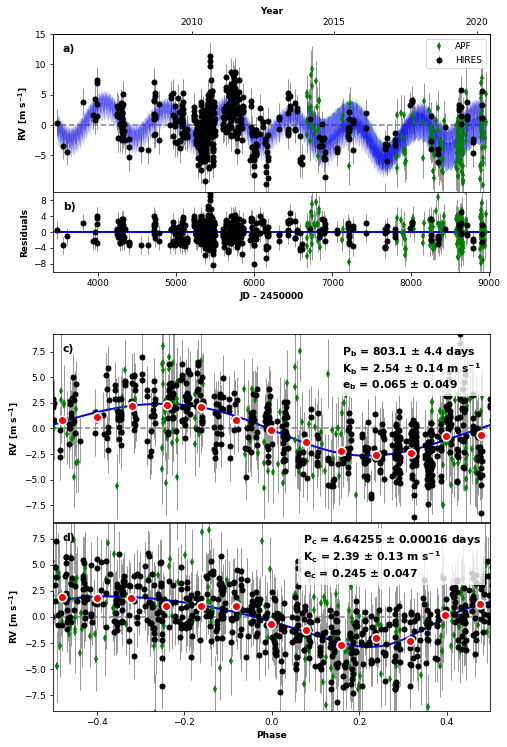

In [118]:
GPPlot = orbit_plots.GPMultipanelPlot(gppost,
         uparams=gppost.uparams,
         saveplot='special_systems/156668_gp.pdf',
         subtract_gp_mean_model=False,
         plot_likelihoods_separately=False,
         subtract_orbit_model=False
         ) #uparams=gppost.uparams,
GPPlot.plot_multipanel()
GPPlot.saveplot()

Corner plot saved to special_systems/154448_gp_corner.pdf


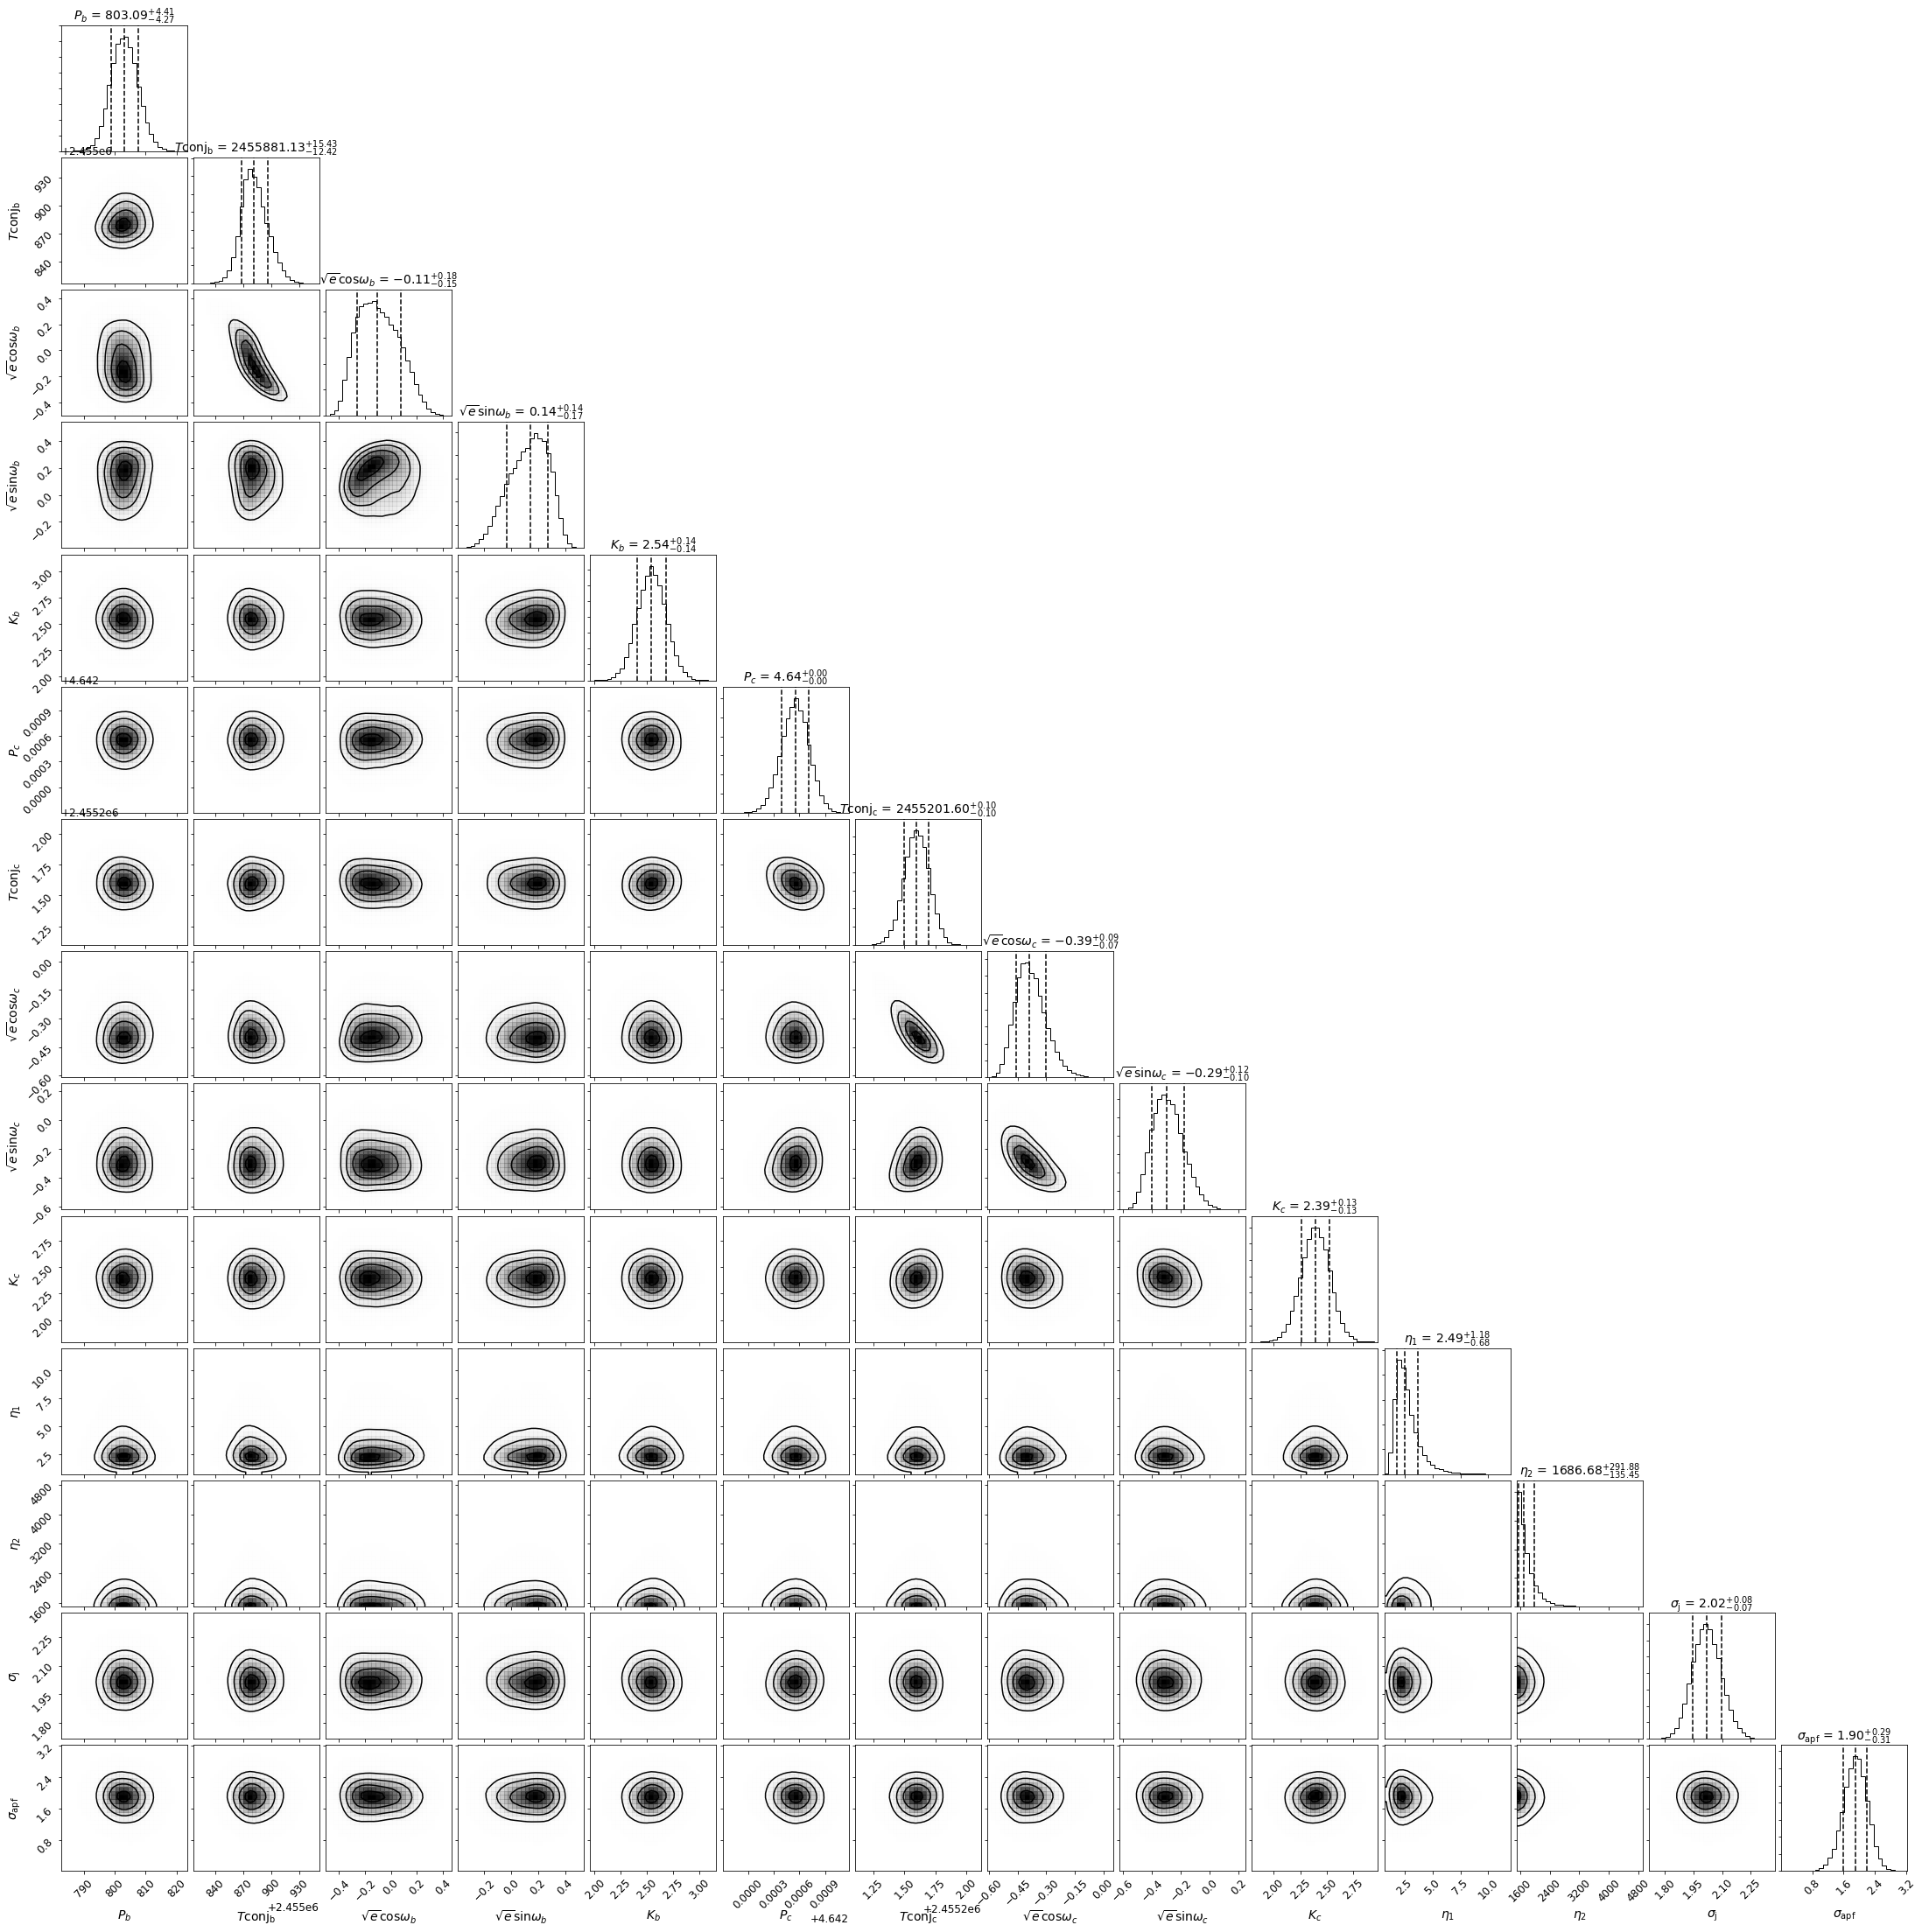

In [107]:
Corner = mcmc_plots.CornerPlot(gppost, cadence_chains,
                               saveplot='special_systems/154448_gp_corner.pdf')
figure = Corner.plot()

## Predict RV increase for 26161.

In [59]:
post = radvel.posterior.load('../funky_systems/26161/post_final.pkl')
data = pd.read_csv('../rvdata/vst26161.csv').query('cts > 3000')

pchains = pd.read_csv('../funky_systems/26161/26161_pchains.csv')
jchains = pd.read_csv('Joker_results/26161_chains_combined.csv').query('M < 40')
# Max is 48
#jchains['tp'] = np.array(data.jd[0]) + jchains['P'] * jchains['M0']/(2*np.pi)

data_k = data.query('tel == "k"')
data_j = data.query('tel == "j"')
data_a = data.query('tel == "apf"')

data_j['mnvel'] = data_j['mnvel'] - post.params['gamma_j'].value
data_k['mnvel'] = data_k['mnvel'] - post.params['gamma_k'].value
data_a['mnvel'] = data_a['mnvel'] - post.params['gamma_apf'].value

data_j['errvel'] = np.sqrt(data_j['errvel']**2 + post.params['jit_j'].value**2)
data_k['errvel'] = np.sqrt(data_k['errvel']**2 + post.params['jit_k'].value**2)

v0 = np.array(data_k.mnvel)[0]
orbel = [post.params['per1'].value,
         post.params['tp1'].value,
         post.params['e1'].value,
         post.params['w1'].value,
         post.params['k1'].value]
mod = radvel.kepler.rv_drive(data['jd'].values, orbel)

In [40]:
print(np.percentile(jchains.M, 15.9), np.percentile(jchains.M, 50), np.percentile(jchains.M, 84.1))
print(np.percentile(jchains.a, 15.9), np.percentile(jchains.a, 50), np.percentile(jchains.a, 84.1))
print(np.percentile(jchains.e, 15.9), np.percentile(jchains.e, 50), np.percentile(jchains.e, 84.1))
print(np.percentile(jchains.P, 15.9), np.percentile(jchains.P, 50), np.percentile(jchains.P, 84.1))
print(np.percentile(jchains.K, 15.9), np.percentile(jchains.K, 50), np.percentile(jchains.K, 84.1))

9.81433439635435 13.356197270275773 21.420598973846644
15.393194962081221 20.20904455004537 27.7145940456694
0.7692450067729453 0.8209832736979169 0.876810507461386
21053.73160702113 31582.594867990487 50871.594264470856
100.71806641950198 139.77966461948478 235.2677344328008


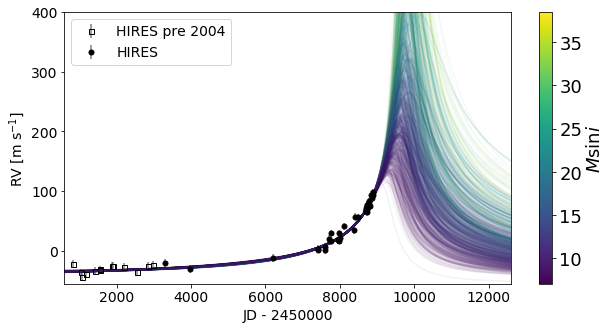

In [62]:
fig, ax = plt.subplots(figsize=(10, 5))
matplotlib.rcParams.update({'font.size': 18})
ax.set_xlabel('JD - 2450000')
ax.set_ylabel(r'RV [m s$^{-1}$]')

markers, caps, bars = ax.errorbar(data_k.jd - 2450000, data_k.mnvel, data_k.errvel,
            fmt='o', marker='s', markerfacecolor='none', 
            markeredgecolor='black', color='black', alpha=1, label='HIRES pre 2004')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]
markers, caps, bars = ax.errorbar(data_j.jd - 2450000, data_j.mnvel, data_j.errvel,
            fmt='o', color='black', alpha=1, label='HIRES')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]
'''
markers, caps, bars = ax.errorbar(data_a.jd - 2450000, data_a.mnvel, data_a.errvel, # - np.median(data_a.mnvel)
            fmt='o', marker='d', color='green', alpha=0.5, label='APF')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]
'''
#norm = Normalize(np.log10(np.amin(jchains.M)), np.log10(np.amax(jchains.M)))
norm = Normalize(np.amin(jchains.M), np.amax(jchains.M))
cmap = cm.viridis #inferno
m = cm.ScalarMappable(norm=norm, cmap=cmap)
m.set_array([])

times = np.linspace(600, 20000, num=1000) #10*(np.amax(data.jd) - np.amin(data.jd))
for i in np.arange(len(jchains)):
    orbel = [np.array(jchains.P)[i],
             np.array(jchains.tper)[i],
             np.array(jchains.e)[i],
             np.array(jchains.omega)[i], #wmod
             np.array(jchains.K)[i]]
    rvmod = radvel.kepler.rv_drive(2450000 + times, orbel) + np.array(jchains.v0)[i]
    ax.plot(times-200, rvmod + 50, color=m.to_rgba(np.array(jchains.M)[i]), alpha=0.05) 
    ax.set_xlim([600, 12600])
    ax.set_ylim([-55, 400])
    
cbar = fig.colorbar(m, ax=ax)
cbar.ax.set_ylabel(r'$M$sin$i$')

matplotlib.rcParams.update({'font.size': 14})
ax.legend()
fig.savefig('Joker_results/26161_orbits.png', dpi=1000, bbox_inches='tight')
fig.savefig('Joker_results/26161_orbits.pdf', bbox_inches='tight')

## SUGGEST THAT WE WILL SEE SOMETHING INTERESTING IN THE NEXT X YEARS

## Do the same for HD 213472.

In [63]:
post = radvel.posterior.load('../funky_systems/213472/post_final.pkl')
data = pd.read_csv('../rvdata/vst213472.csv').query('cts > 3000')

jchains = pd.read_csv('Joker_results/213472_chains.csv').query('M < 8')
#jchains['tp'] = np.array(data.jd[0]) + jchains['P'] * jchains['M0']/(2*np.pi)

data_k = data.query('tel == "k"')
data_j = data.query('tel == "j"')

data_j['mnvel'] = data_j['mnvel'] - post.params['gamma_j'].value
data_k['mnvel'] = data_k['mnvel'] - post.params['gamma_k'].value

#data_j['errvel'] = np.sqrt(data_j['errvel']**2 + post.params['jit_j'].value**2)
#data_k['errvel'] = np.sqrt(data_k['errvel']**2 + post.params['jit_k'].value**2)

v0 = np.array(data_k.mnvel)[0]

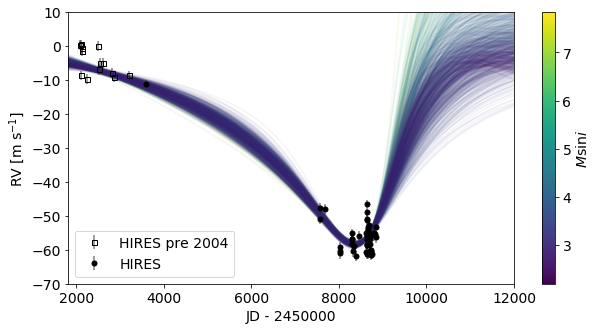

In [64]:
fig, ax = plt.subplots(figsize=(10, 5))
matplotlib.rcParams.update({'font.size': 18})
ax.set_xlabel('JD - 2450000')
ax.set_ylabel(r'RV [m s$^{-1}$]')

markers, caps, bars = ax.errorbar(data_k.jd - 2450000, data_k.mnvel, data_k.errvel,
            fmt='o', marker='s', markerfacecolor='none', 
            markeredgecolor='black', color='black', alpha=1, label='HIRES pre 2004')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]
markers, caps, bars = ax.errorbar(data_j.jd - 2450000, data_j.mnvel, data_j.errvel,
            fmt='o', color='black', alpha=1, label='HIRES')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

norm = Normalize(np.amin(jchains.M), np.amax(jchains.M))
cmap = cm.viridis #inferno
m = cm.ScalarMappable(norm=norm, cmap=cmap)
m.set_array([])

matplotlib.rcParams.update({'font.size': 14})
times = np.linspace(1800, 12000, num=1000)
for i in np.arange(len(jchains)):
    orbel = [np.array(jchains.P)[i],
             np.array(jchains.tper)[i],
             np.array(jchains.e)[i],
             np.array(jchains.omega)[i] + np.pi,
             np.array(jchains.K)[i]]
    rvmod = radvel.kepler.rv_drive(2450000 + times, orbel) + np.array(jchains.v0)[i]
    rvmod0 = radvel.kepler.rv_drive(np.array([np.array(data_k.jd)[0]]), orbel) + np.array(jchains.v0)[i]
    ax.plot(times, rvmod - 55, color=m.to_rgba(np.array(jchains.M)[i]), alpha=0.05) # HOW TO COMPUTE 55?
    # color='blue'
    ax.set_xlim([1800, 12000])
    ax.set_ylim([-70, 10])
    
cbar = fig.colorbar(m, ax=ax)
cbar.ax.set_ylabel(r'$M$sin$i$')
    
ax.legend()
fig.savefig('Joker_results/213472_orbits.png', dpi=1000, bbox_inches='tight')
fig.savefig('Joker_results/213472_orbits.pdf', bbox_inches='tight')

In [50]:
print(np.percentile(jchains.M, 15.9), np.percentile(jchains.M, 50), np.percentile(jchains.M, 84.1))
print(np.percentile(jchains.a, 15.9), np.percentile(jchains.a, 50), np.percentile(jchains.a, 84.1))
print(np.percentile(jchains.e, 15.9), np.percentile(jchains.e, 50), np.percentile(jchains.e, 84.1))
print(np.percentile(jchains.P, 15.9), np.percentile(jchains.P, 50), np.percentile(jchains.P, 84.1))
print(np.percentile(jchains.K, 15.9), np.percentile(jchains.K, 50), np.percentile(jchains.K, 84.1))

2.8845148175054245 3.4792747870300977 4.553364865564593
10.393463173664305 12.990679995335505 18.742690902196003
0.4443397461477272 0.5290556165320334 0.6493562714690058
11939.171717882055 16744.9511136867 28844.636513757374
27.768347776403033 31.132454903599314 38.61993901235222


372


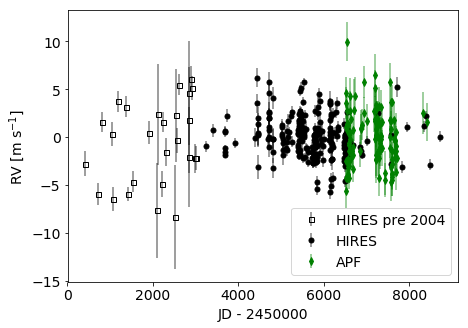

In [14]:
data = pd.read_csv('../rvdata/vst12051.csv')
data = data.query('cts > 3000 and mnvel > -20')

bindata = radvel.utils.bintels(data['jd'].values, data['mnvel'].values, 
                               data['errvel'].values, data['tel'].values)
#pdb.set_trace()
datadict = {'jd': bindata[0], 'mnvel': bindata[1],
           'errvel': bindata[2], 'tel': bindata[3]}
data     = pd.DataFrame(datadict, columns=['jd', 'mnvel', 'errvel', 'tel'])

data_k = data.query('tel == "k"')
data_j = data.query('tel == "j"')
data_a = data.query('tel == "apf"')

print(len(data_k) + len(data_j) + len(data_a))

fig, ax = plt.subplots(figsize=(7, 5))
matplotlib.rcParams.update({'font.size': 18})

ax.set_xlabel('JD - 2450000')
ax.set_ylabel(r'RV [m s$^{-1}$]')

markers, caps, bars = ax.errorbar(data_k.jd - 2450000, data_k.mnvel - np.median(data_k.mnvel), data_k.errvel,
            fmt='o', marker='s', markerfacecolor='none', 
            markeredgecolor='black', color='black', label='HIRES pre 2004')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

markers, caps, bars = ax.errorbar(data_j.jd - 2450000, data_j.mnvel - np.median(data_j.mnvel), data_j.errvel,
            fmt='o', color='black', label='HIRES')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

markers, caps, bars = ax.errorbar(data_a.jd - 2450000, data_a.mnvel - np.median(data_a.mnvel), data_a.errvel,
            fmt='o', marker='d', color='green', label='APF')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

matplotlib.rcParams.update({'font.size': 14})
ax.legend()

fig.savefig('plots/12051_rvs.pdf', bbox_inches='tight')
fig.savefig('plots/12051_rvs.png', dpi=1000, bbox_inches='tight')

108


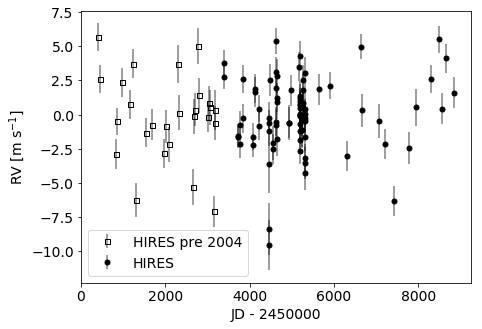

In [5]:
data = pd.read_csv('../rvdata/vst97343.csv')
data_k = data.query('tel == "k"')
data_j = data.query('tel == "j"')
#data_a = data.query('tel == "apf" and cts > 3000')
print(len(data_j) + len(data_k))

fig, ax = plt.subplots(figsize=(7, 5))
matplotlib.rcParams.update({'font.size': 18})

ax.set_xlabel('JD - 2450000')
ax.set_ylabel(r'RV [m s$^{-1}$]')

markers, caps, bars = ax.errorbar(data_k.jd - 2450000, data_k.mnvel - np.median(data_k.mnvel), data_k.errvel,
            fmt='o', marker='s', markerfacecolor='none', 
            markeredgecolor='black', color='black', label='HIRES pre 2004')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

markers, caps, bars = ax.errorbar(data_j.jd - 2450000, data_j.mnvel - np.median(data_j.mnvel), data_j.errvel,
            fmt='o', color='black', label='HIRES')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]
'''
markers, caps, bars = ax.errorbar(data_a.jd - 2450000, data_a.mnvel - np.median(data_a.mnvel), data_a.errvel,
            fmt='o', marker='d', color='green', label='APF')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]
'''
matplotlib.rcParams.update({'font.size': 14})
ax.legend()

fig.savefig('plots/97343_rvs.pdf', bbox_inches='tight')
fig.savefig('plots/97343_rvs.png', dpi=1000, bbox_inches='tight')

In [13]:
np.std(data_j.mnvel)

2.6488642929636095

24


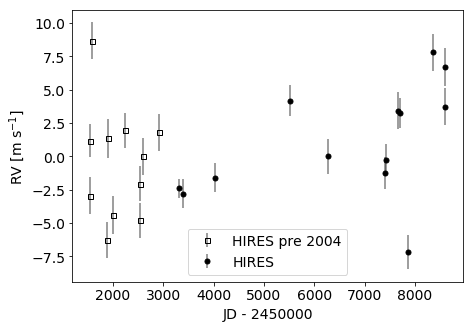

In [15]:
data = pd.read_csv('../rvdata/vst44420.csv')
data = data.query('cts > 3000')

bindata = radvel.utils.bintels(data['jd'].values, data['mnvel'].values, 
                               data['errvel'].values, data['tel'].values)
datadict = {'jd': bindata[0], 'mnvel': bindata[1],
           'errvel': bindata[2], 'tel': bindata[3]}
data     = pd.DataFrame(datadict, columns=['jd', 'mnvel', 'errvel', 'tel'])

data_k = data.query('tel == "k"')
data_j = data.query('tel == "j"')
#data_a = data.query('tel == "apf" and cts > 3000')
print(len(data_j) + len(data_k))

fig, ax = plt.subplots(figsize=(7, 5))
matplotlib.rcParams.update({'font.size': 18})

ax.set_xlabel('JD - 2450000')
ax.set_ylabel(r'RV [m s$^{-1}$]')

markers, caps, bars = ax.errorbar(data_k.jd - 2450000, data_k.mnvel - np.median(data_k.mnvel), data_k.errvel,
            fmt='o', marker='s', markerfacecolor='none', 
            markeredgecolor='black', color='black', label='HIRES pre 2004')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

markers, caps, bars = ax.errorbar(data_j.jd - 2450000, data_j.mnvel - np.median(data_j.mnvel), data_j.errvel,
            fmt='o', color='black', label='HIRES')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]
'''
markers, caps, bars = ax.errorbar(data_a.jd - 2450000, data_a.mnvel - np.median(data_a.mnvel), data_a.errvel,
            fmt='o', marker='d', color='green', label='APF')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]
'''
matplotlib.rcParams.update({'font.size': 14})
ax.legend()

fig.savefig('plots/44420_rvs.pdf', bbox_inches='tight')
fig.savefig('plots/44420_rvs.png', dpi=1000, bbox_inches='tight')

In [15]:
np.std(data_j.mnvel)

4.016199726758566

## Make Msini/a posterior plots for planets beyond 10 AU.

In [2]:
# Start with 213472 and 26161.
jchains213 = pd.read_csv('Joker_results/213472_chains.csv')#.query('M < 8')
jchains261 = pd.read_csv('Joker_results/26161_chains_combined.csv')#.query('M < 8')
chains12 = pd.read_csv('special_systems/120066_pchains.csv')#.sample(1000)#[-1000:]
chains14 = pd.read_csv('special_systems/145675_pchains.csv')#.sample(1000)#[-1000:]
chains50 = pd.read_csv('special_systems/50499_pchains.csv')#.sample(1000)#[-1000:]
chains66 = pd.read_csv('special_systems/66428_pchains.csv')#.sample(1000)#[-1000:]
chains68 = pd.read_csv('special_systems/68988_pchains.csv')#.sample(1000)#[-1000:]
chains92 = pd.read_csv('special_systems/92788_pchains.csv')#.sample(1000)#[-1000:]
chains95 = pd.read_csv('special_systems/95128_pchains.csv')#.sample(1000)#[-1000:]

#120066, 145675, 50499, 66428, 68988, 92788, 95128

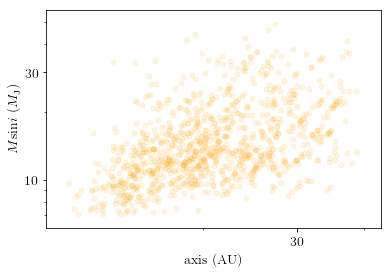

In [25]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.set_xlabel('axis (AU)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\mathrm{J}}$)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((10, 30, 100))
ax.set_yticks((3, 10, 30))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
#'''
#ax.scatter(np.array(chains12.a1), np.array(chains12.M1), alpha=0.1, c='red')
#ax.scatter(np.array(chains14.a2), np.array(chains14.M2), alpha=0.1, c='blue')
#ax.scatter(np.array(chains95.a3), np.array(chains95.M3), alpha=0.1, c='pink')
#ax.scatter(np.array(jchains213.a), np.array(jchains213.M), alpha=0.1, c='yellow')
ax.scatter(np.array(jchains261.a), np.array(jchains261.M), alpha=0.1, c='orange')
#ax.scatter(np.array(chains68.a2), np.array(chains68.M2), alpha=0.1, c='green')
#ax.scatter(np.array(chains50.a2), np.array(chains50.M2), c='yellow', alpha=0.1)
#ax.scatter(np.array(chains92.a2), np.array(chains92.M2), c='purple', alpha=0.1)
#'''

#corner.hist2d(np.array(chains50.a2), np.array(chains50.M2), 
#              no_fill_contours=True, color='blue', ax=ax)
#corner.hist2d(np.array(jchains261.a), np.array(jchains261.M), 
#              no_fill_contours=True, color='purple', ax=ax)

#ax.set_xlim([1, 7])
#ax.set_ylim([8, 30])

#ax.contour(np.array(jchains213.a), np.array(jchains213.M), F, colors='red')
#ax.contour(np.array(jchains261.a), np.array(jchains261.M), F1, colors='blue')

fig.savefig('plots/cold_giant_scatter.pdf', bbox_inches='tight')
fig.savefig('plots/cold_giant_scatter.png', dpi=500, bbox_inches='tight')

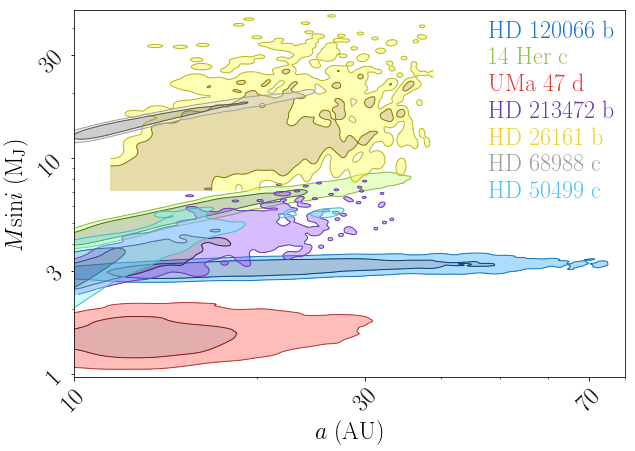

In [3]:
c = chainconsumer.ChainConsumer()

#c.add_chain([np.array(chains66.a2), np.array(chains66.M2)], parameters=["$a$ (AU)", "$M$sin$i$ (M$_J$)"], 
#            name='HD 66428 b', shade=True)
c.add_chain([np.array(chains12.a1), np.array(chains12.M1)], parameters=["$a$ (AU)", "$M$sin$i$ (M$_\mathrm{J}$)"], 
            name='HD 120066 b', shade=True)
c.add_chain([np.array(chains14.a2), np.array(chains14.M2)], parameters=["$a$ (AU)", "$M$sin$i$ (M$_\mathrm{J}$)"], 
            name='14 Her c', shade=True)
c.add_chain([np.array(chains95.a3), np.array(chains95.M3)], parameters=["$a$ (AU)", "$M$sin$i$ (M$_\mathrm{J}$)"], 
            name='UMa 47 d', shade=True)
#'''
c.add_chain([np.array(jchains213.a), np.array(jchains213.M)], parameters=["$a$ (AU)", "$M$sin$i$ (M$_\mathrm{J}$)"], 
            name='HD 213472 b', shade=True)
c.add_chain([np.array(jchains261.a), np.array(jchains261.M)], parameters=["$a$ (AU)", "$M$sin$i$ (M$_\mathrm{J}$)"], 
            name='HD 26161 b', shade=True)
c.add_chain([np.array(chains68.a2), np.array(chains68.M2)], parameters=["$a$ (AU)", "$M$sin$i$ (M$_\mathrm{J}$)"], 
            name='HD 68988 c', shade=True)
#c.add_chain([np.array(chains92.a2), np.array(chains92.M2)], parameters=["$a$ (AU)", "$M$sin$i$ (M$_\mathrm{J}$)"], 
#            name='HD 92788 c', shade=True)
c.add_chain([np.array(chains50.a2), np.array(chains50.M2)], parameters=["$a$ (AU)", "$M$sin$i$ (M$_\mathrm{J}$)"], 
            name='HD 50499 c', shade=True)
#'''
c.configure(plot_contour=True, label_font_size=24, tick_font_size=24, 
            plot_hists=False, smooth=20)

fig = c.plotter.plot(figsize=(6, 3))
fig.set_size_inches(3 + fig.get_size_inches())

ax_list = fig.axes
#'''
ax_list[0].set_xscale('log') #2
ax_list[0].set_yscale('log')
ax_list[0].set_xlim([10, 80])
ax_list[0].set_xticks((10, 30, 70))
ax_list[0].set_yticks((1, 3, 10, 30))
ax_list[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax_list[0].get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax_list[0].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax_list[0].get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
'''
ax_list[2].set_xscale('log') #2
ax_list[2].set_yscale('log')
ax_list[0].set_xscale('log') #2
ax_list[3].set_yscale('log') #2
#ax_list[2].set_xlim([10, 80])
#ax_list[0].set_xlim([10, 80])

#ax_list[2].set_xticks((10, 30, 70))
#ax_list[2].set_yticks((1, 3, 10, 30))
ax_list[2].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax_list[2].get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax_list[2].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax_list[2].get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
'''

fig.savefig('plots/cold_giant_contour.pdf', bbox_inches='tight')
fig.savefig('plots/cold_giant_contour.png', dpi=500, bbox_inches='tight')

In [6]:
np.amin(chains12.M1)

2.50490853905799

## Make orbit gallery for coldest planets.

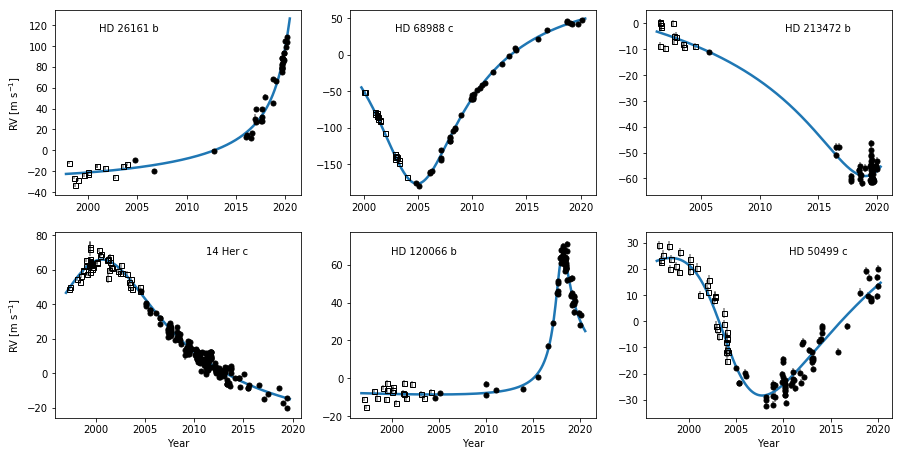

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7.5))#(40, 10))

data  = pd.read_csv('../rvdata/vst26161.csv')
dataj = data.query('tel == "j"').reset_index()
datak = data.query('tel == "k"').reset_index()
post  = radvel.posterior.load('special_systems/26161/post_final.pkl')
times = np.linspace(np.amin(data.jd) - 100, np.amax(data.jd) + 100, num=1000)

years = Time(times, format='jd').byear
yearsk = Time(datak.jd, format='jd').byear
yearsj = Time(dataj.jd, format='jd').byear

orbel = [post.params['per1'].value,
         post.params['tp1'].value,
         post.params['e1'].value,
         post.params['w1'].value,
         post.params['k1'].value]
rvmod = radvel.kepler.rv_drive(times, orbel)

axes[0][0].plot(years, rvmod, lw=2.5)
axes[0][0].text(0.3, 0.9, 'HD 26161 b', ha='center', va='center', transform=axes[0][0].transAxes)
axes[0][0].set_ylabel(r'RV [m s$^{-1}$]')

markers, caps, bars = axes[0][0].errorbar(yearsk, datak.mnvel - 
                                          post.params['gamma_k'].value, datak.errvel,
            fmt='o', marker='s', markerfacecolor='none', 
            markeredgecolor='black', color='black', label='HIRES pre 2004')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

markers, caps, bars = axes[0][0].errorbar(yearsj, dataj.mnvel - 
                                          post.params['gamma_j'].value, dataj.errvel,
            fmt='o', color='black', label='HIRES')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]


data  = pd.read_csv('../rvdata/vst68988.csv')
dataj = data.query('tel == "j"').reset_index()
datak = data.query('tel == "k"').reset_index()
post  = radvel.posterior.load('special_systems/68988/post_final.pkl')
times = np.linspace(np.amin(data.jd) - 100, np.amax(data.jd) + 100, num=1000)

years = Time(times, format='jd').byear
yearsk = Time(datak.jd, format='jd').byear
yearsj = Time(dataj.jd, format='jd').byear

orbel1 = [post.params['per1'].value,
          post.params['tp1'].value,
          post.params['e1'].value,
          post.params['w1'].value,
          post.params['k1'].value]
orbel2 = [post.params['per2'].value,
          post.params['tp2'].value,
          post.params['e2'].value,
          post.params['w2'].value,
          post.params['k2'].value]
orbel3 = [post.params['per3'].value,
          post.params['tp3'].value,
          post.params['e3'].value,
          post.params['w3'].value,
          post.params['k3'].value]

rvmod  = radvel.kepler.rv_drive(times, orbel2)
rvmodk = radvel.kepler.rv_drive(np.array(datak.jd), orbel1) + radvel.kepler.rv_drive(np.array(datak.jd), orbel3)
rvmodj = radvel.kepler.rv_drive(np.array(dataj.jd), orbel1) + radvel.kepler.rv_drive(np.array(dataj.jd), orbel3)

axes[0][1].plot(years, rvmod, lw=2.5)
axes[0][1].text(0.3, 0.9, 'HD 68988 c', ha='center', va='center', transform=axes[0][1].transAxes)

markers, caps, bars = axes[0][1].errorbar(yearsk, datak.mnvel - rvmodk -
                                          post.params['gamma_k'].value, datak.errvel,
            fmt='o', marker='s', markerfacecolor='none', 
            markeredgecolor='black', color='black', label='HIRES pre 2004')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

markers, caps, bars = axes[0][1].errorbar(yearsj, dataj.mnvel - rvmodj -
                                          post.params['gamma_j'].value, dataj.errvel,
            fmt='o', color='black', label='HIRES')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]


data  = pd.read_csv('../rvdata/vst213472.csv')
dataj = data.query('tel == "j"').reset_index()
datak = data.query('tel == "k"').reset_index()
post  = radvel.posterior.load('special_systems/213472/post_final.pkl')
times = np.linspace(np.amin(data.jd) - 100, np.amax(data.jd) + 100, num=1000)

years = Time(times, format='jd').byear
yearsk = Time(datak.jd, format='jd').byear
yearsj = Time(dataj.jd, format='jd').byear

orbel = [post.params['per1'].value,
         post.params['tp1'].value,
         post.params['e1'].value,
         post.params['w1'].value,
         post.params['k1'].value]
rvmod = radvel.kepler.rv_drive(times, orbel)

axes[0][2].plot(years, rvmod - 1, lw=2.5)
axes[0][2].text(0.7, 0.9, 'HD 213472 b', ha='center', va='center', transform=axes[0][2].transAxes)

markers, caps, bars = axes[0][2].errorbar(yearsk, datak.mnvel - 
                                          post.params['gamma_k'].value, datak.errvel,
            fmt='o', marker='s', markerfacecolor='none', 
            markeredgecolor='black', color='black', label='HIRES pre 2004')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

markers, caps, bars = axes[0][2].errorbar(yearsj, dataj.mnvel - 
                                          post.params['gamma_j'].value, dataj.errvel,
            fmt='o', color='black', label='HIRES')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]


data  = pd.read_csv('../rvdata/vst145675.csv')
dataj = data.query('tel == "j"').reset_index()
datak = data.query('tel == "k"').reset_index()
post  = radvel.posterior.load('special_systems/145675/post_final.pkl')
times = np.linspace(np.amin(data.jd) - 100, np.amax(data.jd) + 100, num=1000)

years = Time(times, format='jd').byear
yearsk = Time(datak.jd, format='jd').byear
yearsj = Time(dataj.jd, format='jd').byear

orbel1 = [post.params['per1'].value,
          post.params['tp1'].value,
          post.params['e1'].value,
          post.params['w1'].value,
          post.params['k1'].value]
orbel2 = [post.params['per2'].value,
          post.params['tp2'].value,
          post.params['e2'].value,
          post.params['w2'].value,
          post.params['k2'].value]
orbel3 = [post.params['per3'].value,
          post.params['tp3'].value,
          post.params['e3'].value,
          post.params['w3'].value,
          post.params['k3'].value]

rvmod  = radvel.kepler.rv_drive(times, orbel2)
rvmodk = radvel.kepler.rv_drive(np.array(datak.jd), orbel1) + radvel.kepler.rv_drive(np.array(datak.jd), orbel3)
rvmodj = radvel.kepler.rv_drive(np.array(dataj.jd), orbel1) + radvel.kepler.rv_drive(np.array(dataj.jd), orbel3)

axes[1][0].plot(years, rvmod, lw=2.5)
axes[1][0].text(0.7, 0.9, '14 Her c', ha='center', va='center', transform=axes[1][0].transAxes)
axes[1][0].set_ylabel(r'RV [m s$^{-1}$]')
axes[1][0].set_xlabel('Year')

markers, caps, bars = axes[1][0].errorbar(yearsk, datak.mnvel - rvmodk -
                                          post.params['gamma_k'].value, datak.errvel,
            fmt='o', marker='s', markerfacecolor='none', 
            markeredgecolor='black', color='black', label='HIRES pre 2004')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

markers, caps, bars = axes[1][0].errorbar(yearsj, dataj.mnvel - rvmodj -
                                          post.params['gamma_j'].value, dataj.errvel,
            fmt='o', color='black', label='HIRES')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]


data  = pd.read_csv('../rvdata/vst120066.csv')
dataj = data.query('tel == "j"').reset_index()
datak = data.query('tel == "k"').reset_index()
post  = radvel.posterior.load('special_systems/120066/post_final.pkl')
times = np.linspace(np.amin(data.jd) - 100, np.amax(data.jd) + 100, num=1000)

years = Time(times, format='jd').byear
yearsk = Time(datak.jd, format='jd').byear
yearsj = Time(dataj.jd, format='jd').byear

orbel1 = [post.params['per1'].value,
          post.params['tp1'].value,
          post.params['e1'].value,
          post.params['w1'].value,
          post.params['k1'].value]

rvmod  = radvel.kepler.rv_drive(times, orbel1)

axes[1][1].plot(years, rvmod, lw=2.5)
axes[1][1].text(0.3, 0.9, 'HD 120066 b', ha='center', va='center', transform=axes[1][1].transAxes)
axes[1][1].set_xlabel('Year')

markers, caps, bars = axes[1][1].errorbar(yearsk, datak.mnvel - 
                                          post.params['gamma_k'].value, datak.errvel,
            fmt='o', marker='s', markerfacecolor='none', 
            markeredgecolor='black', color='black', label='HIRES pre 2004')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

markers, caps, bars = axes[1][1].errorbar(yearsj, dataj.mnvel - 
                                          post.params['gamma_j'].value, dataj.errvel,
            fmt='o', color='black', label='HIRES')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]


data  = pd.read_csv('../rvdata/vst50499.csv')
dataj = data.query('tel == "j"').reset_index()
datak = data.query('tel == "k"').reset_index()
post  = radvel.posterior.load('special_systems/50499/post_final.pkl')
times = np.linspace(np.amin(data.jd) - 100, np.amax(data.jd) + 100, num=1000)

years = Time(times, format='jd').byear
yearsk = Time(datak.jd, format='jd').byear
yearsj = Time(dataj.jd, format='jd').byear

orbel1 = [post.params['per1'].value,
          post.params['tp1'].value,
          post.params['e1'].value,
          post.params['w1'].value,
          post.params['k1'].value]
orbel2 = [post.params['per2'].value,
          post.params['tp2'].value,
          post.params['e2'].value,
          post.params['w2'].value,
          post.params['k2'].value]

rvmod  = radvel.kepler.rv_drive(times, orbel2)
rvmodk = radvel.kepler.rv_drive(np.array(datak.jd), orbel1)
rvmodj = radvel.kepler.rv_drive(np.array(dataj.jd), orbel1)

#axes[1][2].plot(times - 2450000, rvmod, lw=2.5)
axes[1][2].plot(years, rvmod, lw=2.5)
axes[1][2].set_xlabel('Year')
axes[1][2].text(0.7, 0.9, 'HD 50499 c', ha='center', va='center', transform=axes[1][2].transAxes)

markers, caps, bars = axes[1][2].errorbar(yearsk, datak.mnvel - rvmodk -
                                          post.params['gamma_k'].value, datak.errvel,
            fmt='o', marker='s', markerfacecolor='none', 
            markeredgecolor='black', color='black', label='HIRES pre 2004')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

markers, caps, bars = axes[1][2].errorbar(yearsj, dataj.mnvel - rvmodj -
                                          post.params['gamma_j'].value, dataj.errvel,
            fmt='o', color='black', label='HIRES')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

fig.savefig('plots/orbit_gallery.pdf', bbox_inches='tight')
fig.savefig('plots/orbit_gallery.png', dpi=500, bbox_inches='tight')